In [1]:
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from collections import Counter, OrderedDict
from rich.pretty import pprint
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Dict, Tuple, Union, Optional, Any, Callable
import functools
from common_utils.core.common import seed_all
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

import math
seed_all(42, seed_torch=True)

42

- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/transformer_from_scratch/transformer_from_scratch.py
- https://peterbloem.nl/blog/transformers
- Show how self attention linear algebra works with simple examples

In [2]:
# %pip install -U torch torchvision torchtext

## Dataset

0 knowledge in NLP...

In this dataset, each pair of sentences represents a single turn in a conversation. The first sentence is the user's input, and the second sentence is the bot's response. 

We define the following variables:

- $\mathcal{V}$: the vocabulary, which contains all the words that can appear in the sentences.
- $N$: the number of sentences in the dataset, or the size of the dataset.

In [3]:
N = 8
VOCAB_SIZE = 16
VOCAB_SIZE_WITH_SPECIAL_TOKENS = VOCAB_SIZE + 4

In [4]:
training_data = [
    ("Hello bot", "Hello human"),
    ("You good", "I bot"),
    ("Tell joke", "Sure thing"),
    ("You are funny", "Thanks"),
    ("Bye bot", "Bye human"),
    ("Bye human", "Bye bot"),
    ("Am I funny.", "You funny"),
    ("I bot", "You human"),
]



In [5]:
# Tokenization
en_tokenizer = get_tokenizer("basic_english")

In [6]:
# Tokenization
tokenizer = get_tokenizer("basic_english")

# Build vocabularies
counter = Counter()
for (user_input, bot_response) in training_data:
    counter.update(tokenizer(user_input))
    counter.update(tokenizer(bot_response))


# Sort the Counter by frequency and create an OrderedDict
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# Create a vocab object
v = vocab(ordered_dict)

# Add special tokens to the counter
specials = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]

# Add special tokens to the vocab
for i, token in enumerate(specials):
    v.insert_token(token, i)

pprint(len(v))
# Print the vocabulary size and the token-to-index and index-to-token mappings
# assert len(v) == VOCAB_SIZE_WITH_SPECIAL_TOKENS

itos: List[str] = v.get_itos()
# assert len(itos) == VOCAB_SIZE_WITH_SPECIAL_TOKENS

stoi: Dict[str, int] = v.get_stoi()

def sort_stoi_by_index(itos: List[str]) -> Dict[str, int]:
    return {token: index for index, token in enumerate(itos)}

stoi_sorted_by_index: Dict[str, int] = sort_stoi_by_index(v.get_itos())

print(f"Vocabulary size: {len(v)}")
print("Token-to-index mapping:")
pprint(stoi_sorted_by_index)


20

Vocabulary size: 20
Token-to-index mapping:


{
│   '<PAD>': 0,
│   '<SOS>': 1,
│   '<EOS>': 2,
│   '<UNK>': 3,
│   'bot': 4,
│   'human': 5,
│   'you': 6,
│   'bye': 7,
│   'i': 8,
│   'funny': 9,
│   'hello': 10,
│   'good': 11,
│   'tell': 12,
│   'joke': 13,
│   'sure': 14,
│   'thing': 15,
│   'are': 16,
│   'thanks': 17,
│   'am': 18,
│   '.': 19
}

In [7]:
# Convert to Tensor
def data_process(raw_text_iter, tokenizer):
    data = [
        torch.tensor(
            [v["<SOS>"]] + [v[token] for token in tokenizer(item)] + [v["<EOS>"]],
            dtype=torch.long,
        )
        for item in raw_text_iter
    ]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))


train_data = []
for (user_input, bot_response) in training_data:
    user_input_tensor = data_process([user_input], tokenizer)
    bot_response_tensor = data_process([bot_response], tokenizer)
    train_data.append((user_input_tensor, bot_response_tensor))

# Let's check the output
pprint(train_data)

[
│   (tensor([ 1, 10,  4,  2]), tensor([ 1, 10,  5,  2])),
│   (tensor([ 1,  6, 11,  2]), tensor([1, 8, 4, 2])),
│   (tensor([ 1, 12, 13,  2]), tensor([ 1, 14, 15,  2])),
│   (tensor([ 1,  6, 16,  9,  2]), tensor([ 1, 17,  2])),
│   (tensor([1, 7, 4, 2]), tensor([1, 7, 5, 2])),
│   (tensor([1, 7, 5, 2]), tensor([1, 7, 4, 2])),
│   (tensor([ 1, 18,  8,  9, 19,  2]), tensor([1, 6, 9, 2])),
│   (tensor([1, 8, 4, 2]), tensor([1, 6, 5, 2]))
]

## Padding

Padding is a common technique used in deep learning when dealing with sequences of varying lengths. Here are a few reasons why padding is necessary:

1. **Uniform Input Size**: Many deep learning models, such as Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), require inputs to have a uniform size. For example, in a batch of sentences, each sentence might have a different number of words. By padding the sentences with a special `<PAD>` token, all sentences in the batch can be made to have the same length, allowing them to be processed as a single tensor.

2. **Efficiency**: Processing sentences one by one can be inefficient. By padding sentences to the same length and forming a batch, we can process multiple sentences at once, leading to faster training times.

3. **Sequence Models**: In sequence-to-sequence models, such as those used in machine translation or chatbot applications, padding is necessary not only to ensure uniform input size, but also to delineate where a sequence starts and ends. Special tokens like `<SOS>` (start of sequence) and `<EOS>` (end of sequence) are often used in conjunction with padding for this purpose.

It's important to note that while padding allows for efficient batch processing and uniform input sizes, it can also introduce noise into the data, as the model needs to learn to ignore these padding tokens. This is often handled in practice by using masking techniques, which explicitly tell the model to ignore certain inputs (like the padding tokens).

### Do we need padding in Transformers?

Yes, the Transformer model does require padding, and here's why:

1. **Batch Processing**: Just like other neural network architectures, Transformers also benefit from processing data in batches for computational efficiency. Since sequences in a batch may have varying lengths, padding is used to ensure all sequences in a batch have the same length.

2. **Masking**: The Transformer uses a mechanism called "attention", which involves looking at all words in the sequence simultaneously. However, we don't want the model to pay attention to the padding tokens, as they don't contain any useful information. Therefore, we create a "mask" that explicitly tells the model to ignore the padding tokens when computing attention. This mask is a sequence of Boolean values indicating which tokens are padding (True) and which are not (False).

3. **Sequence Boundaries**: In sequence-to-sequence tasks (like translation), padding is also used in conjunction with special tokens like `<SOS>` (start of sequence) and `<EOS>` (end of sequence) to indicate the boundaries of the sequence. This helps the model identify when a new sequence starts and when a sequence ends.

So, while the Transformer doesn't inherently require sequences to be of the same length, padding is still a necessary step in the data preprocessing pipeline for the reasons mentioned above.

In [8]:
# Pad the sequences
train_data_padded = []
for (user_input_tensor, bot_response_tensor) in train_data:
    user_input_tensor_padded = pad_sequence(
        [user_input_tensor], padding_value=v["<PAD>"], batch_first=True
    ).squeeze()
    bot_response_tensor_padded = pad_sequence(
        [bot_response_tensor], padding_value=v["<PAD>"], batch_first=True
    ).squeeze()
    train_data_padded.append((user_input_tensor_padded, bot_response_tensor_padded))

# Let's check the output
pprint(train_data_padded)

[
│   (tensor([ 1, 10,  4,  2]), tensor([ 1, 10,  5,  2])),
│   (tensor([ 1,  6, 11,  2]), tensor([1, 8, 4, 2])),
│   (tensor([ 1, 12, 13,  2]), tensor([ 1, 14, 15,  2])),
│   (tensor([ 1,  6, 16,  9,  2]), tensor([ 1, 17,  2])),
│   (tensor([1, 7, 4, 2]), tensor([1, 7, 5, 2])),
│   (tensor([1, 7, 5, 2]), tensor([1, 7, 4, 2])),
│   (tensor([ 1, 18,  8,  9, 19,  2]), tensor([1, 6, 9, 2])),
│   (tensor([1, 8, 4, 2]), tensor([1, 6, 5, 2]))
]

So I do not see any changes
The `pad_sequence` function is designed to pad a batch of sequences, not a single sequence. In the code, you're applying `pad_sequence` to each pair of sentences individually, which is why you're not seeing any padding.

So each data point is a batch, i.e. batch size = 1, so there's no need for padding
and therefore no effect.

To see the padding in action, you would need to apply `pad_sequence` to a batch of sentences. Here's an example where we take the first and fourth sentence of
different lengths and pad them to have the same length. The batch size is 2.

In [9]:
# Let's take the first two pairs of sentences as a batch
batch = [train_data[0], train_data[3]]
pprint(batch[0]) # (4, 4)
pprint(batch[1]) # (5, 3)

(tensor([ 1, 10,  4,  2]), tensor([ 1, 10,  5,  2]))

(tensor([ 1,  6, 16,  9,  2]), tensor([ 1, 17,  2]))

After padding, we expect the input tensor to be of shape 

```python
(batch_size, max_seq_len) = (2, 5)
```

and the response tensor to be of shape 

```python
(batch_size, max_seq_len) = (2, 4)
```

In [10]:
# Separate the user inputs and bot responses
user_inputs, bot_responses = zip(*batch)

# Pad the user inputs
user_inputs_padded = pad_sequence(
    user_inputs, padding_value=v["<PAD>"], batch_first=True
)

# Pad the bot responses
bot_responses_padded = pad_sequence(
    bot_responses, padding_value=v["<PAD>"], batch_first=True
)

# Let's check the output
print("User inputs (padded):")
pprint(user_inputs_padded)
print("Bot responses (padded):")
pprint(bot_responses_padded)


User inputs (padded):


tensor([[ 1, 10,  4,  2,  0],
│   │   [ 1,  6, 16,  9,  2]])

Bot responses (padded):


tensor([[ 1, 10,  5,  2],
│   │   [ 1, 17,  2,  0]])


In this code, we first create a batch of sentences by taking the first two pairs of sentences from `train_data`. We then separate the English and French sentences, and pad each set of sentences using `pad_sequence`.

This should give you padded sentences where all sentences in a batch have the same length. The shorter sentences in the batch are padded with the `<PAD>` token to make them the same length as the longest sentence in the batch.

However, in practice, you would typically handle padding in the `collate_fn` function when you create your `DataLoader`, as this allows you to create batches of any size and automatically pad the sentences in each batch to the correct length.

## Intuition

So far, the intuition is simple, to convert words in sentences to numbers,
we achieved this through a series of preprocessing steps such as tokenization,
padding, and attention mask. 


## Dataset class.

In [11]:
class ChatDataset(Dataset):
    def __init__(
        self,
        data: List[Tuple[str, str]],
        tokenizer_type: str = "basic_english",
        specials: List[str] = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"],
    ) -> None:
        self.data = data
        self.tokenizer_type = tokenizer_type
        self.tokenizer = get_tokenizer(tokenizer_type)
        self.specials = specials
        self.vocab = self.build_vocab()
        self.padded_data = self.pad_data()

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        input_ids, target_ids = self.padded_data[index]
        item = {
            "input_ids": input_ids,
            "attention_mask": (input_ids != self.vocab["<PAD>"]).type(torch.long),
            "target_ids": target_ids,
        }
        return item

    def __len__(self) -> int:
        return len(self.padded_data)
    
    @property
    def vocab_size(self) -> int:
        return len(self.vocab)

    def build_vocab(self) -> vocab:
        counter = Counter()
        for (user_input, bot_response) in self.data:
            counter.update(self.tokenizer(user_input))
            counter.update(self.tokenizer(bot_response))

        sorted_by_freq_tuples = sorted(
            counter.items(), key=lambda x: x[1], reverse=True
        )
        ordered_dict = OrderedDict(sorted_by_freq_tuples)

        v = vocab(ordered_dict)
        for i, token in enumerate(self.specials):
            v.insert_token(token, i)

        return v

    def pad_data(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        train_data_padded = []
        for (user_input, bot_response) in self.data:
            user_input_tensor = self._text_to_tensor(user_input)
            bot_response_tensor = self._text_to_tensor(bot_response)
            user_input_tensor_padded = self._pad_sequence(user_input_tensor)
            bot_response_tensor_padded = self._pad_sequence(bot_response_tensor)
            train_data_padded.append(
                (user_input_tensor_padded, bot_response_tensor_padded)
            )
        return train_data_padded

    def _text_to_tensor(self, text: str) -> torch.Tensor:
        return torch.tensor(
            [self.vocab["<SOS>"]]
            + [self.vocab[token] for token in self.tokenizer(text)]
            + [self.vocab["<EOS>"]],
            dtype=torch.long,
        )

    def _pad_sequence(self, tensor: torch.Tensor) -> torch.Tensor:
        return pad_sequence(
            [tensor], padding_value=self.vocab["<PAD>"], batch_first=True
        ).squeeze()

In [12]:
dataset = ChatDataset(training_data)

assert len(dataset) == N

If you run the below code, you get error

```python
RuntimeError: stack expects each tensor to be equal size, but got [6] at entry 0 and [5] at entry 1
```

because you have different length of sentences in the batch.
So we need to apply padding properly.

In [13]:
# Use DataLoader
# batch_size = 2
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Iterate over data
# for i, batch in enumerate(dataloader):
#     print(f"Batch {i+1}")
#     print(f"Input IDs: {batch['input_ids']}")
#     print(f"Attention Mask: {batch['attention_mask']}")
#     print(f"Target IDs: {batch['target_ids']}")


In [14]:
def collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    input_ids = [item['input_ids'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]
    
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=dataset.vocab["<PAD>"])
    target_ids = pad_sequence(target_ids, batch_first=True, padding_value=dataset.vocab["<PAD>"])
    
    attention_mask = (input_ids != dataset.vocab["<PAD>"]).type(torch.long)
    
    return {
        "input_ids": input_ids, 
        "attention_mask": attention_mask,
        "target_ids": target_ids
    }


I set `shuffle=False` because I want to keep the order of the data for easy
visualization later.

In [15]:
# Use DataLoader
def create_dataloader(
    dataset: Dataset, batch_size: int, shuffle: bool = True, **kwargs: Dict[str, Any]
) -> DataLoader:
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)


batch_size = 2
dataloader = create_dataloader(
    dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)


# Iterate over data
for i, batch in enumerate(dataloader):
    if i == 3:
        print(f"Batch {i+1}\n")
        print(
            f"Input IDs:\n{np.array2string(batch['input_ids'].numpy(), separator=', ')}\n"
        )
        print(
            f"Attention Mask:\n{np.array2string(batch['attention_mask'].numpy(), separator=', ')}\n"
        )
        print(
            f"Target IDs:\n{np.array2string(batch['target_ids'].numpy(), separator=', ')}"
        )


Batch 4

Input IDs:
[[ 1, 18,  8,  9, 19,  2],
 [ 1,  8,  4,  2,  0,  0]]

Attention Mask:
[[1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 0, 0]]

Target IDs:
[[1, 6, 9, 2],
 [1, 6, 5, 2]]


We see the last batch and input ids and target ids are easy, but the
attention mask means that the model should not pay attention to the
padding tokens. As we know they are a bit like dummy tokens.

```python
(tensor([ 1, 18,  8,  9, 19,  2]), tensor([1, 6, 9, 2])),
(tensor([1, 8, 4, 2]), tensor([1, 6, 5, 2]))
```

In the context of transformer models such as BERT or GPT, an attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to these positions.

The attention mechanism in transformer models allows them to focus on different words in the input sequence when producing the output. However, when processing the input data, we often pad shorter sentences with special tokens (like "<PAD>") to make all sentences the same length. We don't want the model to focus on these padding tokens, as they don't contain any useful information.

The attention mask has the same length as the input sequence and has a value of 1 for real tokens and a value of 0 for padding tokens. It tells the model to ignore (by setting to zero) the attention scores of padding tokens so that they don't affect the result.

## First layer - Word embeddings + Positional embeddings

In the original "Attention is All You Need" paper where Transformers were first introduced, the authors proposed the use of two types of embeddings: token embeddings and position embeddings.

1. **Token Embeddings**: These are the embeddings that we commonly refer to when talking about word embeddings. They are learned from the data and represent the individual words (or tokens) from the vocabulary. For example, the words "queen" and "king" will have their unique vectors in this embedding space.

2. **Position Embeddings**: These are an additional type of embedding introduced specifically in Transformers. They represent the position of a word in a sentence. This is important because unlike previous architectures like RNNs, Transformers do not have an inherent understanding of the position or order of words in a sentence. These position embeddings are added to the token embeddings to give the model information about the position of the words.

In summary, the first block in the Transformer's architecture is a combination of token and position embeddings. Both are vital for the model to understand the data correctly. If you would like to only focus on token embeddings for now, you can just use the `nn.Embedding` layer in PyTorch, but it's important to remember that this will only get you part way to replicating the Transformer's architecture.

We look at the first part, the token embeddings, in more detail below.

### Token Embeddings

The first layer in a transformer is indeed the embedding layer. This layer takes in words as input and outputs corresponding dense vectors. These vectors capture semantic meanings of the words, and words with similar meanings have vectors that are close in the vector space.

An embedding layer is essentially a simple lookup table that's learned from data. It is a matrix where each row corresponds to a vector for a particular word in the vocabulary. The dimension of these vectors, also called the embedding dimension, is a hyperparameter. 

The intuition here is to transform sparse one-hot vectors representing words into dense vectors with lower dimensionality. These dense vectors can capture relationships between words in a more expressive way than the original one-hot vectors.

In PyTorch, you can create an embedding layer using `nn.Embedding`. Here's how you can do it for your transformer:


In [16]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
        super(TokenEmbedding, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embedding_dim)
        
        self.init_weights()

    def init_weights(self) -> None:
        nn.init.kaiming_normal_(self.token_emb.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.token_emb(x)

In [17]:
# Usage
embedding_dim = 3
embedding_layer = TokenEmbedding(len(dataset.vocab), embedding_dim)

# After you've loaded your batch from your dataloader
for i, batch in enumerate(dataloader):
    if i == 0:
        input_ids = batch["input_ids"]
        embedded_sequences = embedding_layer(input_ids)

        pprint(input_ids)
        pprint(embedded_sequences)
        break

tensor([[ 1, 10,  4,  2],
│   │   [ 1,  6, 11,  2]])

tensor([[[-0.2766, -1.0947, -0.4780],
│   │    [ 0.2163,  1.0395, -0.7271],
│   │    [-0.8569,  0.4931, -1.4062],
│   │    [ 0.4378,  0.4284, -1.1996]],
│   │   
│   │   [[-0.2766, -1.0947, -0.4780],
│   │    [-2.0490,  0.3985,  0.6406],
│   │    [ 0.3346, -1.1897, -0.0836],
│   │    [ 0.4378,  0.4284, -1.1996]]], grad_fn=<EmbeddingBackward0>)

In the above code, `nn.Embedding(vocab_size, embedding_dim)` creates an embedding layer with `vocab_size` number of embeddings each of dimension `embedding_dim`. 

In the `forward` method, we compute token embeddings of the input ids by passing them through the embedding layer. 

This is a very simple embedding layer for a transformer. In reality, you might want to add more complexity like dropout, layer normalization, and positional encoding instead of simple position embeddings. Also, transformer-based models like BERT use subword tokenization, which adds another layer of complexity to the embedding layer. But this should give you a good starting point.

### What is the `nn.Embedding` layer?

When you use an embedding layer like `nn.Embedding` in PyTorch, what you are effectively doing is learning a kind of word2vec (or similar) model as part of your larger model. The `nn.Embedding` layer is initialized with random weights, and these weights are then adjusted during training through backpropagation. The goal is to learn word embeddings that are useful for the specific task your model is trying to achieve. 

This is slightly different from using a pre-trained word embedding like word2vec or GloVe. In those cases, the embeddings are trained beforehand on a large corpus of text with the aim of capturing semantic similarities between words. These pre-trained embeddings can be useful when you don't have a lot of training data, or when you want to leverage the semantic knowledge captured by these models.

When training a Transformer model from scratch, it's common to learn the embeddings from scratch as well, as part of the model. This allows the model to learn embeddings that are tailored to the specific task it's trying to solve. However, it's also possible to use pre-trained embeddings, especially in cases where the training data is limited.

In summary, using `nn.Embedding` in PyTorch doesn't preclude the use of word2vec-like embeddings. It's just a different approach, and the right one to use depends on the specifics of your task and dataset.

So this embeddings below corresponds to the first two data points (sentences).

```python
tensor([[[-0.2766, -1.0947, -0.4780],
│   │    [ 0.2163,  1.0395, -0.7271],
│   │    [-0.8569,  0.4931, -1.4062],
│   │    [ 0.4378,  0.4284, -1.1996]],
│   │   
│   │   [[-0.2766, -1.0947, -0.4780],
│   │    [-2.0490,  0.3985,  0.6406],
│   │    [ 0.3346, -1.1897, -0.0836],
│   │    [ 0.4378,  0.4284, -1.1996]]], grad_fn=<EmbeddingBackward0>)
```

#### Why is first and last token always the same?

The reason why the first and the last embeddings are the same is due to the use of special tokens `<SOS>` (Start Of Sentence) and `<EOS>` (End Of Sentence) in your sequences. In your pre-processing steps, each sentence is surrounded by these special tokens.

When you feed these sequences into the `TokenEmbedding` layer, each unique token gets a unique embedding. Since the `<SOS>` token is always the first token in your sequences, it always gets the same embedding. The same goes for the `<EOS>` token, which is always the last token in your sequences.

Hence, for every sequence, the first and the last embeddings are the same because they correspond to the `<SOS>` and `<EOS>` tokens, respectively. The embeddings for these tokens do not change unless the model is trained and the weights of the embedding layer get updated.

You might see different weights for the `<SOS>` and `<EOS>` tokens in different batches if you shuffle your dataset between epochs and train your model, because the model is learning to update the weights of these tokens based on the context in which they appear.

That being said, note that the purpose of these special tokens is not to carry semantic meaning like the other words in the vocabulary, but to provide structural information to the model. In the case of transformers, they also provide positions for the positional encodings.

#### First Input ID drill down

To drill down further, let's just consider the first data point.

In [18]:
first_input = dataset[0]["input_ids"]
pprint(first_input)

first_input_embeddings = embedded_sequences[0]
pprint(first_input_embeddings)

# equivalent to:
assert_equal = functools.partial(torch.testing.assert_close, rtol=0, atol=0)
assert_equal(first_input_embeddings, embedding_layer.token_emb(first_input))

tensor([ 1, 10,  4,  2])

tensor([[-0.2766, -1.0947, -0.4780],
│   │   [ 0.2163,  1.0395, -0.7271],
│   │   [-0.8569,  0.4931, -1.4062],
│   │   [ 0.4378,  0.4284, -1.1996]], grad_fn=<SelectBackward0>)

In the scenario you've outlined:

1. The sentence "Hello bot" has been preprocessed into the sequence of token IDs `[1, 10, 4, 2]`. 

2. Your `TokenEmbedding` model is learning a unique vector representation (i.e., an embedding) for each unique token ID in your vocabulary.

    ```python
    tensor([[-0.2766, -1.0947, -0.4780],
    │   │   [ 0.2163,  1.0395, -0.7271],
    │   │   [-0.8569,  0.4931, -1.4062],
    │   │   [ 0.4378,  0.4284, -1.1996]], grad_fn=<SelectBackward0>)
    ```

3. When you pass your sequence of token IDs `[1, 10, 4, 2]` into your `TokenEmbedding` model, it looks up the vector representation for each token ID in the sequence, effectively converting your sequence of token IDs into a sequence of embeddings.

4. The tensor that is output by the model represents these embeddings. Each row in the tensor corresponds to the embedding for the respective token ID in your sequence.

In summary, your understanding is correct: the tensor represents the "learnt word/token embeddings" for the input sentence.

and its weights.

In the context of neural networks, "weights" often refer to the parameters that the model learns during training. These are the values that are updated in each iteration of the optimization process, with the aim to minimize the loss function.

The Embedding layer in PyTorch is essentially a lookup table that maps each token in the vocabulary to a vector in a high-dimensional space. The "weights" in the Embedding layer are the values of these vectors. Each row in the weight matrix corresponds to the vector for a specific token.

For a vocabulary of `vocab_size` and an embedding size of `embedding_dim`, the Embedding layer will have a weight matrix of shape `(vocab_size, embedding_dim)`. Each row of this matrix is the embedding vector for a corresponding token in the vocabulary. For example, the first row of the matrix is the vector for the token with ID 0, the second row is for the token with ID 1, and so on.

When the model is initialized, these weights are usually assigned random values. During training, the model learns the appropriate values for these weights based on the training data. The goal is to arrange the vectors in such a way that semantically similar words are located close to each other in the embedding space.

To summarize, the weights in the Embedding layer represent the embeddings for each token in the vocabulary. They are the parameters that the model needs to learn from the data during training.

In [19]:
token_embeddings_weight = embedding_layer.token_emb.weight
pprint(token_embeddings_weight)

Parameter containing:
tensor([[ 0.2762,  1.3874,  0.0089],
│   │   [-0.2766, -1.0947, -0.4780],
│   │   [ 0.4378,  0.4284, -1.1996],
│   │   [ 1.1702,  0.6074, -0.3932],
│   │   [-0.8569,  0.4931, -1.4062],
│   │   [-0.6759, -0.4063,  0.3876],
│   │   [-2.0490,  0.3985,  0.6406],
│   │   [ 0.0234,  0.5232,  0.4762],
│   │   [ 0.1789,  0.4512, -0.1513],
│   │   [ 0.6146,  0.3305,  0.1457],
│   │   [ 0.2163,  1.0395, -0.7271],
│   │   [ 0.3346, -1.1897, -0.0836],
│   │   [-0.4892,  0.3895,  0.5929],
│   │   [ 0.0744,  3.2951,  1.0447],
│   │   [-0.0104,  0.1966,  0.0598],
│   │   [ 0.6684,  1.2088,  0.2816],
│   │   [-1.1628, -0.0950, -0.7942],
│   │   [ 0.7826, -1.1705, -0.4626],
│   │   [-0.3472,  0.2143, -1.1750],
│   │   [ 0.4257,  0.2848,  0.7900]], requires_grad=True)

In [20]:
first_input.shape, first_input_embeddings.shape, token_embeddings_weight.shape

(torch.Size([4]), torch.Size([4, 3]), torch.Size([20, 3]))

In [21]:
# Convert the first token ID to a one-hot encoded vector
first_input_onehot = F.one_hot(first_input, num_classes=len(dataset.vocab)).float()
pprint(first_input_onehot)

# Perform a matrix multiplication between the one-hot vector and the embedding weight matrix
first_input_embedding_via_matmul = torch.matmul(first_input_onehot, token_embeddings_weight)
# Now, first_token_embedding_via_matmul should be the same as first_token_embedding
pprint(first_input_embedding_via_matmul)

# Now, first_input_embedding_via_matmul should be the same as first_input_embeddings
assert_equal(first_input_embeddings, first_input_embedding_via_matmul)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
│   │    0., 0.],
│   │   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
│   │    0., 0.],
│   │   [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
│   │    0., 0.],
│   │   [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
│   │    0., 0.]])

tensor([[-0.2766, -1.0947, -0.4780],
│   │   [ 0.2163,  1.0395, -0.7271],
│   │   [-0.8569,  0.4931, -1.4062],
│   │   [ 0.4378,  0.4284, -1.1996]], grad_fn=<MmBackward0>)

#### Intuition 1

In [22]:
hello_weight = token_embeddings_weight[stoi_sorted_by_index['hello']]
pprint(hello_weight)

tensor([ 0.2163,  1.0395, -0.7271], grad_fn=<SelectBackward0>)

##### The weight is the embedding of the word (token)

Yes, exactly! In the context of the `nn.Embedding` layer in PyTorch, the weights are indeed the embeddings. 

When you have a sentence and you convert each word/token to its corresponding ID, you use these IDs as indices to lookup in the embedding table (weights). The row from the embedding table (weights) corresponding to the ID is the embedding vector for that word/token. 

So in essence, the weights in the embedding layer are the learned embeddings for each word/token in your vocabulary. 

This is a good realization to make as it highlights the fact that in machine learning models, weights are not just random numbers, but they often have interpretable meanings. In this case, the weights are the learned vector representations of words.

- `tensor([ 0.2163,  1.0395, -0.7271], grad_fn=<SelectBackward0>)` 
    - is the weight corresponding to the token (word) `hello` in the vocabulary corpus.
    - is also the word/token representation (embedding) of the word `hello` in the vocabulary corpus.
    - Why so? Because one-hot encoding ensures that the weight corresponding to the token (word) `hello` is 1 and the weights corresponding to all other tokens (words) are 0. So, the dot product of the one-hot encoded vector of the word `hello` with the embedding matrix will be the weight corresponding to the token (word) `hello` in the vocabulary corpus.

In [23]:
hello_embeddings = hello_weight 

Thus, for the first input setence `Hello bot`, the encoded embedding for 
this sentence is four tokens (including the special tokens).

In [24]:
pprint(first_input_embeddings)

tensor([[-0.2766, -1.0947, -0.4780],
│   │   [ 0.2163,  1.0395, -0.7271],
│   │   [-0.8569,  0.4931, -1.4062],
│   │   [ 0.4378,  0.4284, -1.1996]], grad_fn=<SelectBackward0>)

And notice the `[ 0.2163,  1.0395, -0.7271]` weight we got corresponding to `hello`
is indeed here, in the output embeddings 2nd row, which is indeed `hello` since
the full first sentence is `<SOS> hello bot <EOS>`.

##### am i right to say at this stage, the learnt embeddings are on a token level and not on a sentence level

At the embedding stage, the model is learning embeddings for individual tokens and not for entire sentences. 

Each token in your vocabulary is associated with a unique vector in the embedding space, irrespective of the context in which the token appears. This means that the same word has the same embedding regardless of its position in the sentence or the other words in the sentence. 

However, it's important to note that this is the initial step in the transformer model. The transformer architecture uses these individual token embeddings and, with its self-attention mechanism, generates context-aware embeddings where the representation of a word does consider its context within a sentence. These context-aware embeddings are what is used for downstream tasks like text classification, named entity recognition, etc. 

So while the initial embeddings are at the token level, the transformer architecture builds on top of this to generate embeddings that capture the context of a token within a sentence.


#### Intuition (To refine)

Emphasize again, that this stage is just the embedding space for individual tokens
or words, not the sentence, the output of each input sentence here is just a
stack of vectors (learnt word embeddings) for each word in the sentence.

Semantically related words such as 'King' and 'Queen' are represented in the vector space such that the geometric relationships between these vectors capture the semantic relationships between the corresponding words. So if you visualize in a 2d space,
then king and queen are closer than that of men and women.

In the context of Word Embeddings:

Word embeddings are the result of mapping words or phrases from the vocabulary to vectors of real numbers. They are capable of capturing the context of a word in a document, semantic and syntactic similarity, and other relevant linguistic patterns. 

Here is an example to give a clear idea of how word embeddings capture relationships:

Let's say we have four words: King, Queen, Man, Woman. After training the word embeddings (like Word2Vec, GloVe, etc.) on a large corpus, these words are mapped into a high-dimensional space. 

The relationships between these words are captured as vectors in this space. For example, if we subtract the vector for 'Man' from 'King' and add the vector for 'Woman', we get a vector that is very close to the vector for 'Queen'.

Mathematically: 

    Vector('King') - Vector('Man') + Vector('Woman') ≈ Vector('Queen')

This is because the word embeddings have learned that 'King' is to 'Queen' what 'Man' is to 'Woman' from the co-occurrence statistics in the training corpus. This is known as an analogy relationship in word embeddings.

Remember that while this analogy works well in many cases, it's not always perfect and depends largely on the training data and the quality of the embeddings.

## Stage 1. Token (Word) Embeddings

In [25]:
training_data_simple = [
    ("hello bot", "hello human"),
    ("hello hello human", "hello bot"),
]

dataset = ChatDataset(
    data=training_data_simple,
    tokenizer_type="basic_english",
    specials=["<SOS>", "<EOS>", "<PAD>"],
)

batch_size = 1
dataloader = create_dataloader(
    dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

In [26]:
for i, batch in enumerate(dataloader):
    print(f"Batch {i+1}\n")
    print(
        f"Input IDs:\n{np.array2string(batch['input_ids'].numpy(), separator=', ')}\n"
    )
    print(
        f"Attention Mask:\n{np.array2string(batch['attention_mask'].numpy(), separator=', ')}\n"
    )
    print(
        f"Target IDs:\n{np.array2string(batch['target_ids'].numpy(), separator=', ')}"
    )

Batch 1

Input IDs:
[[0, 3, 4, 1]]

Attention Mask:
[[1, 1, 1, 1]]

Target IDs:
[[0, 3, 5, 1]]
Batch 2

Input IDs:
[[0, 3, 3, 5, 1]]

Attention Mask:
[[1, 1, 1, 1, 1]]

Target IDs:
[[0, 3, 4, 1]]


In [27]:
itos: List[str] = dataset.vocab.get_itos()
pprint(itos)

V_mathcal = itos # our $\mathcal{V}$
V = len(V_mathcal) # our $V = |\mathcal{V}|$

stoi_sorted_by_index: Dict[str, int] = sort_stoi_by_index(itos)
pprint(stoi_sorted_by_index)

['<SOS>', '<EOS>', '<PAD>', 'hello', 'bot', 'human']

{'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, 'hello': 3, 'bot': 4, 'human': 5}

In [28]:
batch = next(iter(dataloader))
pprint(batch)

{
│   'input_ids': tensor([[0, 3, 4, 1]]),
│   'attention_mask': tensor([[1, 1, 1, 1]]),
│   'target_ids': tensor([[0, 3, 5, 1]])
}

- We are interested in only the `input_ids` now.

In [29]:
X = batch["input_ids"] # our $\mathbf{X}$
pprint(X)
pprint(X.shape)

tensor([[0, 3, 4, 1]])

torch.Size([1, 4])

- The first `input` is the sentence `hello bot`.
- The tokenization is `[0, 3, 4, 1]` which correctly maps to the tokens `[<SOS>, hello, bot, <EOS>]` as per the `stoi` mapping.
- The shape is `[1, 4]` because we have one sentence with 4 tokens, where the first token is the `<SOS>` token and the last token is the `<EOS>` token.
    - In this context, the first dimension of the shape corresponds to the number of sentences (or samples) in the batch, and the second dimension corresponds to the number of tokens in each sentence.

---

In mathematical terms, we have:

- The vocabulary $\mathcal{V}$ consists of the unique tokens $\{\text{<SOS>, <EOS>, <PAD>, hello, bot, human}\}$ in our text data. The size of the vocabulary is $V = |\mathcal{V}| = 6$.

- We define a function $f_{\text{stoi}}$ that maps each token in our vocabulary to a unique integer index. 
  
  $$
  \begin{aligned}
  f_{\text{stoi}}: \mathcal{V} &\to \{0, 1, ..., V-1\} \\
  v &\mapsto f_{\text{stoi}}(v)
  \end{aligned}
  $$
  
  This function represents the `stoi` mapping in the code. For example, $f_{\text{stoi}}(\text{<SOS>}) = 0$, $f_{\text{stoi}}(\text{hello}) = 3$, etc.

- A sequence of text, such as the sentence "hello bot", is represented as a sequence of token indices $X=(x_1, x_2, x_3, x_4)$ using the $f_{\text{stoi}}$ mapping. For the sentence "hello bot", we have:
  
    $$
    \begin{aligned}
    \mathbf{X} &= (f_{\text{stoi}}(\text{<SOS>}), f_{\text{stoi}}(\text{hello}), f_{{\text{stoi}}}(\text{bot}), f_{\text{stoi}}(\text{<EOS>})) \\
    &= (0, 3, 4, 1)
    \end{aligned}
    $$

- Although $\mathbf{X}$ is a sequence, we can consider it to be a vector:

    $$
    \mathbf{X} = \begin{bmatrix} 0 & 3 & 4 & 1 \end{bmatrix} \in \mathbb{Z}^{1 \times 4}
    $$

    which correctly corresponds to the shape `[1, 4]` in the code.

Next, we need to map each token to a vector in a high-dimensional space. The vectors we use are called embeddings. The integer tokens, by themselves, do not carry much information. For example, the word `hello` is tokenized to be $3$, which is an arbitrary integer. In a one-dimensional Euclidean space, the word `hello` and the next word `bot`, indexed by $4$, ***would appear to be very close to each other***. However, if we were to extend the vocabulary to say, a size of $10000$, and the word `bot` is instead indexed at $9999$, then the words `hello` and `bot` ***would appear to be very far from each other***. This means that the model would not recognize any relationship between these two words based on their tokenized integers. To address this, we use embedding vectors. While the initial mapping from words to vectors is arbitrary, during training, the model adjusts these vectors so that words used in similar contexts come to have similar vectors. This allows the model to capture semantic relationships between words, improving its ability to understand and generate meaningful text.

### One-hot encoding

One-hot encoding is a common technique used in machine learning to represent categorical variables, such as our tokens. In the context of Natural Language Processing (NLP), one-hot encoding means representing each token as an $V$-dimensional vector. Each token is represented by a vector of all zeros except for a single one at the position corresponding to its index in the vocabulary. Therefore, the token 'hello' which corresponds to the index 3 in the vocabulary would be represented as the vector `[0, 0, 0, 1, 0, 0]`. This step is necessary as it allows us to convert the tokens into a format that can be processed by the embedding layer.

In [30]:
O = F.one_hot(X, num_classes=len(dataset.vocab)).float() # our one-hot encoding $\mathbf{O}$
pprint(O)
pprint(O.shape)

tensor([[[1., 0., 0., 0., 0., 0.],
│   │    [0., 0., 0., 1., 0., 0.],
│   │    [0., 0., 0., 0., 1., 0.],
│   │    [0., 1., 0., 0., 0., 0.]]])

torch.Size([1, 4, 6])

- Recall our tokenized sequence is `[0, 3, 4, 1]`.
- Converting it to one-hot encoding, we get:
    - `[1, 0, 0, 0, 0, 0]`
    - `[0, 0, 0, 1, 0, 0]`
    - `[0, 0, 0, 0, 1, 0]`
    - `[0, 1, 0, 0, 0, 0]`
- The shape has turned from `[1, 4]` to be broadcasted to `[1, 4, 6]` corresponding to the sequence length and the vocabulary size. Or more concretely `[batch_size, sequence_length, vocab_size]`.
- For simplicity sake, you can remove the first dimension, the batch index, and just use `[4, 6]`. The `4` is the sequence length and the `6` is the vocabulary size.

---

In mathematical terms, we have:

Using these notations, we can say that our tokenized sequence $\mathbf{X}$ is converted to a one-hot matrix $O$ of size $[L, V]$ (or more generally $[N, L, V]$ in the presence of batch size $N$). 

In the given example, $\mathbf{X} = [0, 3, 4, 1]$, which is of size $[4]$, and after one-hot encoding, we get $O$, a $[4, 6]$ matrix as follows:

$$
O = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \end{bmatrix} \in \mathbb{R}^{4 \times 6}
$$

where

- $4$ is the sequence length $L$.
- $6$ is the vocabulary size $V$.
- Each row is a one-hot vector of the token $x_{\ell} \in \mathbb{R}^{V}$ at position $\ell$.

A minute quirk here is that the token $x_{\ell}$ exists in the ***continuous space***
instead of the ***discrete space***. This is because we have to perform the dot product between the one-hot vector and the embedding vector, which is a continuous vector.

The reason is that these spaces will be used in computations that involve real-valued numbers, especially when the models are trained with gradient-based optimization algorithms, where the parameters of the model are updated using real-valued gradients.

Therefore, in our code, we also converted the one-hot vector to `.float()`.

### Embedding Layer/Matrix

Now, let's introduce the concept of an "embedding" which is a way to transform our one-hot encoded vectors into a lower, or sometimes higher, dimensional space that is easier to process by the model and, more importantly, contains meaningful representation of the words. Embedding also helps the model understand the semantic relationships between the words. Each unique word in our vocabulary is associated with an embedding, which is a real-valued vector.

Usually, it is a lower dimension because our vocabulary size is in the tens
of thousands and the embedding dimension are typically $512$ or $768$.

Here, our vocabulary size is $V=6$ and the embedding dimension is $D=2$.

In [31]:
seed_all(42, seed_torch=True)
D = embedding_dim = 2
token_emb = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embedding_dim)
nn.init.kaiming_normal_(token_emb.weight)

E = embedding_weight_matrix = token_emb.weight # E for embedding weights
pprint(E)
pprint(E.shape)

Parameter containing:
tensor([[ 1.1103, -1.6898],
│   │   [-0.9890,  0.9580],
│   │   [ 1.3221,  0.8172],
│   │   [-0.7658, -0.7506],
│   │   [ 1.3525,  0.6863],
│   │   [-0.3278,  0.7950]], requires_grad=True)

torch.Size([6, 2])

We use PyTorch's embedding layer to create our embeddings. The embedding layer is simply a linear layer that maps the one-hot encoded input to the embedding space. This layer has a weight matrix, often called the embedding matrix, which is a $V \times D$ matrix where $V$ is the size of the vocabulary and $D$ is the desired embedding dimension.

It is of course randomly initialized, and it is learned during the training of the model. 

So for now, the embedding matrix is:

$$
\mathbf{E} = \begin{bmatrix} 1.1103 & -1.6898 \\ -0.9890 & 0.9580 \\ 1.3221 & 0.8172 \\ -0.7658 & -0.7506 \\ 1.3525 & 0.6863 \\ -0.3278 & 0.7950 \end{bmatrix} \in \mathbb{R}^{6 \times 2}
$$

This is a $6 \times 2$ matrix where each row represents the embedding vector of a word in the vocabulary. The matrix is in $\mathbb{R}^{V \times D}$, where $V$ is the vocabulary size and $D$ is the embedding dimension. In this case, $V = 6$ and $D = 2$.

The element $e_{j, d}$ at the $j$-th row and the $d$-th column is the $d$-th element of the embedding vector of the $j$-th word in the vocabulary.

We want to associate each token with a $D$ dimensional vector, as mentioned earlier.
This is to associate each token with a more meaningful representation.

In our example:

- `[1.1103, -1.6898]` is the embedding vector of the token `<SOS>`.
- `[-0.9890, 0.9580]` is the embedding vector of the token `<EOS>`.
- `[1.3221, 0.8172]` is the embedding vector of the token `<PAD>`.
- `[-0.7658, -0.7506]` is the embedding vector of the token `hello`.
- `[1.3525, 0.6863]` is the embedding vector of the token `bot`.
- `[-0.3278, 0.7950]` is the embedding vector of the token `human`.


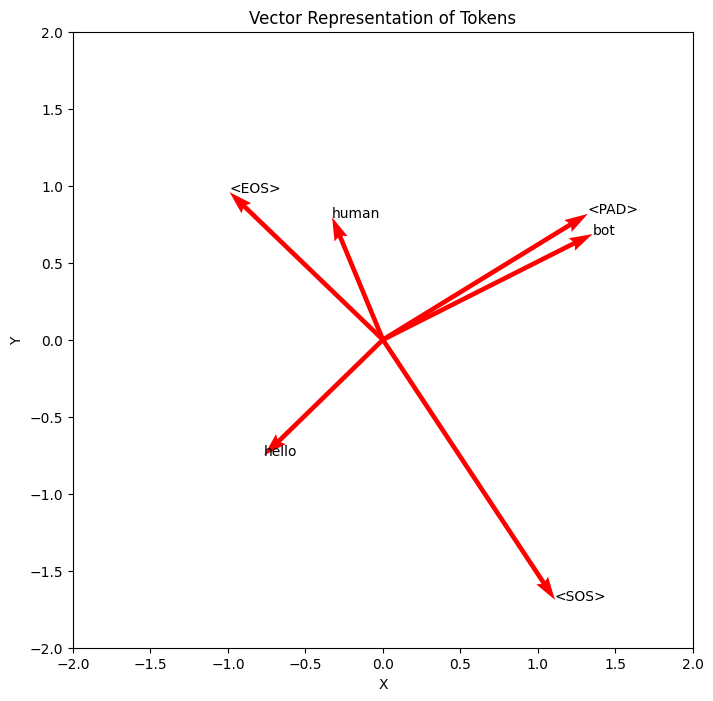

In [32]:
vectors = {
    "<SOS>": [1.1103, -1.6898],
    "<EOS>": [-0.9890, 0.9580],
    "<PAD>": [1.3221, 0.8172],
    "hello": [-0.7658, -0.7506],
    "bot": [1.3525, 0.6863],
    "human": [-0.3278, 0.7950],
}

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for word, vec in vectors.items():
    ax.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax.text(vec[0], vec[1], word)

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Vector Representation of Tokens')
plt.show()

Measuring how close each vector is semantically can be formalized by cosine
similarity, essentially intuition is measuring the angle between two vectors.

In [33]:
# Calculate cosine similarity
cos_sim = cosine_similarity(E.detach().numpy())

# Your vocabulary
# V_mathcal = ["<SOS>", "<EOS>", "<PAD>", "hello", "bot", "human"]
pprint(V_mathcal)

# Create a DataFrame
df = pd.DataFrame(cos_sim, index=V_mathcal, columns=V_mathcal)

df

['<SOS>', '<EOS>', '<PAD>', 'hello', 'bot', 'human']

,<SOS>,<EOS>,<PAD>,hello,bot,human
<SOS>,1.000000,-0.975899,0.027705,0.192830,0.111513,-0.981955
<EOS>,-0.975899,1.000000,-0.245178,0.025946,-0.325689,0.917019
<PAD>,0.027705,-0.245178,1.000000,-0.975513,0.996471,0.161838
hello,0.192830,0.025946,-0.975513,1.000000,-0.953609,-0.374917
bot,0.111513,-0.325689,0.996471,-0.953609,1.000000,0.078435
human,-0.981955,0.917019,0.161838,-0.374917,0.078435,1.000000


In [34]:
Z = torch.matmul(O, E) 
pprint(Z)
pprint(Z.shape)

tensor([[[ 1.1103, -1.6898],
│   │    [-0.7658, -0.7506],
│   │    [ 1.3525,  0.6863],
│   │    [-0.9890,  0.9580]]], grad_fn=<UnsafeViewBackward0>)

torch.Size([1, 4, 2])

This is our $\mathbf{Z}$, each row is the embedding vector of a word in the vocabulary. Note that these values are initially random, and they are learned during the training of the model.

It is no surprise the dimension is $4 \times 4$, which is $L \times D$, the 
length of the sequence times the dimension of the embedding vector.

### Positional Embeddings

VISIT after attention.

The code below wont work as of now because the `embedding_dim` is odd. It needs to be even.

$P$ is not learnable. It is a fixed matrix.


In [35]:
class PositionalEncoding(nn.Module):
    def __init__(
        self, embedding_dim: int, dropout: float = 0.1, max_len: int = 3
    ) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.P = self._init_positional_encoding()

    def _init_positional_encoding(self):
        """Initialize the positional encoding tensor."""
        P = torch.zeros((1, self.max_len, self.embedding_dim))
        position = self._get_position_vector()
        div_term = self._get_div_term_vector()
        P[:, :, 0::2] = torch.sin(position / div_term)
        P[:, :, 1::2] = torch.cos(position / div_term)
        return P

    def _get_position_vector(self):
        """Return a vector representing the position of each token in a sequence."""
        return torch.arange(self.max_len, dtype=torch.float32).reshape(-1, 1)

    def _get_div_term_vector(self):
        """Return a vector representing the divisor term for positional encoding."""
        return torch.pow(
            10000,
            torch.arange(0, self.embedding_dim, 2, dtype=torch.float32)
            / self.embedding_dim,
        )

    def forward(self, Z):
        Z = self._add_positional_encoding(Z)
        return self.dropout(Z)

    def _add_positional_encoding(self, Z):
        """Add the positional encoding tensor to the input tensor."""
        return Z + self.P[:, : Z.shape[1], :].to(Z.device)

In the `forward` method of the `PositionalEncoding` class, the positional encoding is added to the input `X`:

```python
def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device)
    return self.dropout(X)
```

This method slices the precalculated positional encodings tensor `self.P` to match the sequence length of `X`, adds it to `X`, and then applies dropout. The result, which is the sum of the original embeddings and the positional encodings, is returned. So there's no need to add the positional encodings to `X` outside of this class.

So when you call `positional_encoding(Z)`, it adds the positional encodings to `Z` and applies dropout, then returns the result. You could store this result in `Z_with_pos_encodings` or just overwrite it as `Z`:

```python
Z = positional_encoding(Z)
```

Now, `Z` contains the original embeddings with the positional encodings added and dropout applied.

In [36]:
max_len = 10
dropout = 0
D = embedding_dim = 2 # same as earlier

positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, dropout=dropout, max_len=max_len)
Z = positional_encoding(Z)
pprint(Z)
pprint(Z.shape)

tensor([[[ 1.1103, -0.6898],
│   │    [ 0.0756, -0.2103],
│   │    [ 2.2618,  0.2702],
│   │    [-0.8478, -0.0320]]], grad_fn=<AddBackward0>)

torch.Size([1, 4, 2])

In the context of your "hello bot" example, the original tensor `Z` represented the word embeddings, where each token in the sequence (i.e., `SOS`, `hello`, `bot`, `EOS`) was converted into a 2-dimensional vector capturing the semantic meaning of each token. After adding positional encoding, the new tensor represents both the semantic and positional information of each token in the sequence.

- The first row (`[1.1103, -0.6898]`) now encapsulates both the meaning of the `SOS` token and the information that it's the first token in the sequence.

- The second row (`[0.0756, -0.2103]`) is now a representation of the word `hello` that carries not just its semantics (e.g., being a greeting), but also the information that it's the second word in the sentence.

- The third row (`[2.2618, 0.2702]`) likewise carries both the semantics of `bot` (likely related to AI or technology), and its position as the third word in the sentence.

- The last row (`[-0.8478, -0.0320]`) encapsulates the semantics of `EOS` token, signifying end of a sentence, and the fact that it's the last token in the sentence.

The idea here is that in natural language, word order matters. The sentence "hello bot" is not the same as "bot hello" (okay maybe it is the same in this example, a better one is cat eat mouse isn't the same as mouse eat cat).

So, in a language model, we want our representations to capture not just what words mean, but also where they are in a sentence. Positional encoding is a technique to achieve this goal.

Again, it's important to note that the exact interpretation of these values is not straightforward. They are the result of complex transformations and learned during the training process to minimize the loss function. They don't have a clear, individual meaning that humans can easily understand. This is a common characteristic of the inner workings of deep learning models.

### More Intuition with P added (Pretty bad analogy, to revise)

Let's revise the analogy using the sentence "Mary visited the museum in Paris."

The original word embeddings (Z) can be thought of as guests at a party, where each guest represents a word: 'Mary,' 'visited,' 'the,' 'museum,' 'in,' and 'Paris.' The personality of each guest represents the semantic meaning of the word they represent. 

Now, let's think of the positional encoding (P) as the order in which these guests arrived at the party. This captures the positional information in the sentence. 'Mary' was the first to arrive, 'visited' the second, and so on.

When we add the positional encoding to the original embeddings (Z = Z + P), we're basically combining the personality of each guest (the meaning of the word) with their arrival order at the party (their position in the sentence). 

So, for example, 'Mary' isn't just represented as a proper noun referring to a person, but she's also identified as the first person who arrived at the party. Similarly, 'Paris' isn't just a proper noun referring to a city, but it's the last entity that arrived.

This way, the combined tensor (Z = Z + P) captures both the semantic meaning and the positional information for each word, allowing the Transformer to understand both the meaning of the words and their order in the sentence. This is crucial because, in many languages, changing the order of words can drastically alter the meaning of a sentence.

### Piecing it together 


...

Note if you use the `TokenEmbedding` layer, you do not need to one-hot encode
the input $X$ since it will be done automatically.

In [37]:
# seed_all(42, seed_torch=True)
# embedding_layer = TokenEmbedding(len(dataset.vocab), embedding_dim=embedding_dim)

# Z = embedding_layer(X)
# pprint(Z)

## Attention

- https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms#:~:text=The%20meaning%20of%20query%2C%20value,the%20same%20tensor%20as%20value.
- https://d2l.ai/chapter_attention-mechanisms-and-transformers/queries-keys-values.html


### Example Simple

- Query:

    The Query vector, like the word embedding, is a learned representation of the word. However, while the word embedding represents the semantic meaning of the word itself, the Query vector represents how the word should be used as a query to attend to other words.

    In other words, the Query vector captures the "asking" aspect of the word in the context of the sentence. It's used to compute attention scores with the Key vectors of other words. The more similar the Query vector is to a Key vector of another word (as measured by their dot product), the more attention the model should pay to that word.

    So, in the case of our example, the Query vector [1.15157688, 1.26007255] for "cat" determines how "cat" attends to other words in the sentence. For instance, if the Key vector for "mat" is very similar to this Query vector, then "cat" would pay more attention to "mat" in the computation of the output vectors. However, "cat" will also attend to all other words in the sentence, with the amount of attention determined by the similarity of the Query vector for "cat" to the Key vector of each other word.

    Remember, these Query (and Key, and Value) vectors are typically learned during the training process. They are updated iteratively to minimize the prediction error of the model on a set of training examples. As such, they can capture complex patterns in the data and help the model make accurate predictions.

    However, it's important to note that the actual values in these vectors can be difficult to interpret directly. They don't necessarily correspond to intuitive features of the words. Instead, they should be understood in relation to each other: the attention mechanism is essentially learning to use these vectors to weigh the importance of different words when processing each individual word in the sentence.

  - More intuition: In this example, "the cat sat on the mat", the "Query" vector for the word "cat" can be thought of as posing the queries: "What is the cat doing?" and "Where is the cat?" As we move forward, we'll see that this "Query" vector interacts with the "Key" vectors of all other words in the sentence. The goal is for this "learned query representation" to align well with the "Key" vectors of words that provide meaningful responses to the queries posed. For instance, the word "mat" becomes a key part of answering the question "Where is the cat?", and so we would want the "Query" vector for "cat" and the "Key" vector for "mat" to have a high degree of alignment.

- Value, the output of the attention.

    The final value vector of a word after the attention mechanism captures not just the word's individual meaning, but also its context within the sentence. It's a more sophisticated representation that captures how the word interacts with all other words in the sentence.

    One way to think about this is as a form of feature engineering. The attention mechanism allows the model to automatically learn features that capture important relationships between words. In our example, the final value vector for "cat" could capture the fact that "cat" is the subject of the sentence, that it's performing an action ("sat"), and that this action is happening in a specific location ("on the mat"). 

    To provide an example of how this could be useful, consider a downstream task like sentiment analysis. The sentiment of a sentence often depends on the relationships between words, not just the words themselves. For example, consider the difference between the sentences "The cat sat on the mat" and "The cat did not sit on the mat". The presence of the word "not" changes the meaning of the sentence, and this change is captured by the relationships between the words.

    By using the attention mechanism, the model can learn to capture these relationships, and thus it can learn to better perform tasks like sentiment analysis. The final value vector for each word captures a rich set of features that reflect both the word's individual meaning and its context within the sentence, and these features can be very useful for many natural language processing tasks.

In [38]:
# Word embeddings for "the", "cat", "sat", "on", "mat"
embeddings = np.array([[0.1, 0.1],  # "the"
                       [1, 1],      # "cat"
                       [0.2, -0.1], # "sat"
                       [0.2, -0.1], # "on"
                       [1, 1]])     # "mat"

# Initialize the Query, Key, and Value weight matrices
np.random.seed(0)
Q_weight_matrix = np.random.rand(2, 2)
K_weight_matrix = np.random.rand(2, 2)
V_weight_matrix = np.random.rand(2, 2)

# Compute the Query, Key, and Value vectors for each word
Q = np.dot(embeddings, Q_weight_matrix)
K = np.dot(embeddings, K_weight_matrix)
V = np.dot(embeddings, V_weight_matrix)

Q, K, V


(array([[0.11515769, 0.12600725],
        [1.15157688, 1.26007255],
        [0.04948636, 0.08854955],
        [0.04948636, 0.08854955],
        [1.15157688, 1.26007255]]),
 array([[0.0861242 , 0.15376671],
        [0.86124201, 1.53766711],
        [0.04097224, 0.04000152],
        [0.04097224, 0.04000152],
        [0.86124201, 1.53766711]]),
 array([[0.17553878, 0.09123364],
        [1.7553878 , 0.91233644],
        [0.11356005, 0.02379881],
        [0.11356005, 0.02379881],
        [1.7553878 , 0.91233644]]))

In [39]:
# Compute the attention scores
attention_scores = Q @ K.T

# Print the attention scores
attention_scores


array([[0.02929359, 0.29293585, 0.00975875, 0.00975875, 0.29293585],
       [0.29293585, 2.92935851, 0.0975875 , 0.0975875 , 2.92935851],
       [0.01787795, 0.17877947, 0.00556968, 0.00556968, 0.17877947],
       [0.01787795, 0.17877947, 0.00556968, 0.00556968, 0.17877947],
       [0.29293585, 2.92935851, 0.0975875 , 0.0975875 , 2.92935851]])

Next, we apply the softmax function to these scores. This will convert the scores into probabilities that sum to 1. It will also amplify high scores and suppress low scores. The softmax function is applied to each row of the matrix separately.

In [40]:
# Compute softmax
softmax_scores = np.exp(attention_scores) / np.sum(np.exp(attention_scores), axis=1, keepdims=True)

# Print the softmax scores
softmax_scores


array([[0.17970633, 0.23391698, 0.17622986, 0.17622986, 0.23391698],
       [0.03271029, 0.45673907, 0.02690578, 0.02690578, 0.45673907],
       [0.18780496, 0.22058994, 0.18550758, 0.18550758, 0.22058994],
       [0.18780496, 0.22058994, 0.18550758, 0.18550758, 0.22058994],
       [0.03271029, 0.45673907, 0.02690578, 0.02690578, 0.45673907]])

We've computed the softmax scores, which are probabilities indicating how much each word should attend to every other word. You'll notice that now the words "cat" and "mat" pay most attention to themselves and each other, as their embeddings are the same. The words "sat" and "on" also pay most attention to themselves and each other, but less to "cat" and "mat". The word "the" is somewhat evenly spread, but with a slightly higher attention to "cat" and "mat".

Finally, let's compute the output vectors for each word. We do this by multiplying the softmax scores by their corresponding Value vectors (element-wise) and summing them up. This produces the output of the self-attention layer at this position (for the initially processed word). This output vector is a weighted sum of all Value vectors, where the weights are the attention scores. This means that words with higher attention scores have a greater influence on the output.

In [41]:
# Compute the output vectors
output_vectors = softmax_scores @ V

# Print the output vectors
output_vectors


array([[0.89280079, 0.45160535],
       [1.61536116, 0.83766433],
       [0.84954134, 0.42846834],
       [0.84954134, 0.42846834],
       [1.61536116, 0.83766433]])

The resulting matrix contains the output vectors for each word in the sentence: "the", "cat", "sat", "on", and "mat". These vectors are influenced by all other words in the sentence, with the degree of influence determined by the attention scores.

In this particular example, the words "cat" and "mat" have similar output vectors, which are also influenced by the other words, but mostly by "cat" and "mat" themselves. This reflects the fact that these words are similar (in our simple representation) and that they should pay attention to each other. Similarly, the words "sat" and "on" have similar output vectors, indicating that they are related to each other in the context of this sentence.

The word "the" has a different output vector, which is a result of the attention paid to all other words. This illustrates the power of the attention mechanism: it allows each word to consider the context provided by all other words, with the amount of consideration determined by the attention scores.

This ability to consider all parts of the input when processing each word, and to learn how much attention to pay to each part, is what makes the self-attention mechanism so powerful for tasks like language modeling. It allows the model to capture complex dependencies between words, regardless of their distance from each other in the sentence.

### Queries, Keys and Values

#### Intuition

First, let's visualize this with human's own brain attention mechanism.

Consider the sentence:

> Mary visited the museum in Paris.

Sure, let's continue with the intuition.

As we read the word **Mary**, our brain starts to search for the context or information related to Mary. This is the **query**. 

Next, we move on to the word **visited**. Now, our brain starts to form a connection between Mary and the action of visiting. The word "visit" acts as a **key** to unlock more information about the context.

As we continue to read and reach the phrase **the museum in Paris**, our brain recognizes this as the **value** or the object of Mary's visit. 

So, in this sentence, "Mary" is the query, "visited" is the key, and "the museum in Paris" is the value. Our brain's attention mechanism works by associating queries and keys to extract relevant values or information.

> This process happens for each word in the sentence. The attention mechanism is not limited to just one query, key, and value. It can be applied to multiple queries, keys, and values.

In the context of the Transformer model, the queries, keys, and values are all vectors that are computed from the input data. The model uses these to determine how much attention should be paid to each part of the input when generating each part of the output. This allows the model to handle long-range dependencies in the data, such as the connection between "Mary" and "the museum in Paris" in our example sentence.

---

Let's consider the sentence: "Mary visited the museum in Paris."

To understand how attention mechanisms work in a Transformer model, let's imagine we are trying to understand the role of each word in the sentence.

Here is a conceptual explanation of what the Queries (Q), Keys (K), and Values (V) might represent:

- **Queries (Q):** Each word in the sentence can have a query. For instance, when processing the word "visited", the query could be "Who did the visiting?" or "What was visited?". Similarly, when processing the word "museum", the query could be "Who or what is related to the museum?".

- **Keys (K):** Each word in the sentence also has a key. These keys give us more context about each word. For "Mary", the key could represent the idea that Mary is a person. For "visited", the key might encapsulate the notion of an action performed by someone. For "museum", the key might represent the idea of a place or a destination.

- **Values (V):** Values are the actual context or information each word provides. If a key matches a query, the Transformer model will fetch the value related to that key. For example, for the query "Who did the visiting?" when processing "visited", the key for "Mary" would match this query, and thus the value that "Mary" is the one who did the visiting is obtained.

In the attention mechanism, every word (through its query) interacts with every other word (through their keys), and based on these interactions, attention scores are calculated. These scores decide how much focus should be placed on each word in the sentence while processing a particular word.

Again, this is a simplified explanation. In practice, Q, K, and V are all high-dimensional vectors, and these interactions involve complex mathematical operations like dot products and softmax operations.

The aim of the Transformer model is to understand the relationship between words in a sentence. In the given example sentence, it helps the model understand the relationship between "Mary", "visited", "museum", and "Paris", and that "Mary" is the one who did the visiting, the "museum" is the object being visited, and the event took place in "Paris". 

I hope this analogy helps to visualize the attention mechanism better.

#### Q, K and V

In the sentence "hello bot", "hello" is a greeting and "bot" is the entity being greeted. This sentence, in a conversation, might be a user's first interaction with a chatbot. The user is saying hello to the bot. 

Now, let's break this down in terms of queries (Q), keys (K), and values (V):

- The Queries (Q): In the context of the Transformer model trying to understand or generate a response to "hello bot", the model might form a **query** for the word "hello" as "What is the intent behind this token?" and another query for "bot" as "Who is being addressed here?".

- The Keys (K): The model has learned representations (keys) for all the words in its training data. So, it has keys for both "hello" and "bot". For "hello", a key might be its function as a common greeting. For "bot", a key might be its role as a term referring to a software application.

- The Values (V): The values are the representations that correspond to the keys. If the model's keys for "hello" and "bot" match with the queries it has formed, it will fetch the corresponding values. These values, in practice, are vector representations carrying the semantic information of the words. The values might tell the model that "hello" is a polite way to initiate a conversation and "bot" is the addressee here.

Remember, this is all abstract and conceptual. In practice, Q, K, and V are all numerical vectors that the model learns to associate with each input token. These vectors are used to calculate the attention scores, which determine how much each word in the sentence contributes to the understanding of every other word in the sentence.

The primary role of the transformer is to understand the context of each word in relation to every other word in the sentence, which is a crucial requirement in understanding natural language. For example, it needs to understand that "bot" is being greeted, which is an insight it gets by paying attention to both "hello" and "bot" simultaneously.

In [42]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, embedding_dim: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.q_linear = nn.Linear(embedding_dim, embedding_dim)
        self.k_linear = nn.Linear(embedding_dim, embedding_dim)
        self.v_linear = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.embedding_dim)
        attention_weights = F.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        return output

#### Single Head

In [43]:
Z

tensor([[[ 1.1103, -0.6898],
         [ 0.0756, -0.2103],
         [ 2.2618,  0.2702],
         [-0.8478, -0.0320]]], grad_fn=<AddBackward0>)

In [44]:
H = num_heads = 1
d_q = d_k = d_v = D // H
pprint(d_q)

# W_q = nn.Linear(D, d_q)
W_q = torch.randn(D, d_q, requires_grad=True)
pprint(W_q)

Q = Z @ W_q

W_k = torch.randn(D, d_k, requires_grad=True)
K = Z @ W_k

W_v = torch.randn(D, d_v, requires_grad=True)
V = Z @ W_v

pprint(Q)
pprint(K)
pprint(V)

2

tensor([[ 0.2815,  0.0562],
│   │   [ 0.5227, -0.2384]], requires_grad=True)

tensor([[[-0.0480,  0.2268],
│   │    [-0.0886,  0.0544],
│   │    [ 0.7780,  0.0626],
│   │    [-0.2554, -0.0400]]], grad_fn=<UnsafeViewBackward0>)

tensor([[[-0.0495,  0.0815],
│   │    [-0.0020, -0.1135],
│   │    [-0.1152,  1.3875],
│   │    [ 0.0426, -0.4696]]], grad_fn=<UnsafeViewBackward0>)

tensor([[[ 0.8484,  1.5723],
│   │    [ 0.2237,  0.2523],
│   │    [ 0.0267,  1.7141],
│   │    [-0.0804, -0.7041]]], grad_fn=<UnsafeViewBackward0>)

Let's unpack the variables `Q`, `K`, and `V` and what their values represent. All these variables are derived from the input matrix `Z` and learned weights `W_q`, `W_k`, and `W_v` for each attention head.

1. **Query matrix (`Q`)**: 

    `Q` is the result of the dot product between the input matrix `Z` and the weight matrix `W_q` for the query. In your case, `Q` has the shape of (1, 4, 2), which represents (batch size, sequence length, feature dimension). 

    Each entry in `Q` essentially represents a "question" or "request for information" associated with the corresponding element of the input. These questions will be used to interact with the keys to derive attention scores.

    The actual values in the `Q` matrix are computed from the input data and the parameters of the model. They don't necessarily have an intuitive interpretation because they are learned in a data-driven way to achieve the task that the model is trained for (e.g., language modeling, machine translation).

2. **Key matrix (`K`)**: 

    `K` is the result of the dot product between the input matrix `Z` and the weight matrix `W_k` for the key. `K` also has the shape of (1, 4, 2).

    Each entry in `K` represents a "key" or "identifier" associated with the corresponding element of the input. The keys are used in conjunction with the queries to calculate the attention scores. 

    As with the queries, the values in the `K` matrix are learned from the data and don't necessarily have an intuitive interpretation.

3. **Value matrix (`V`)**: 

    `V` is the result of the dot product between the input matrix `Z` and the weight matrix `W_v` for the value. `V` also has the shape of (1, 4, 2).

    Each entry in `V` represents a "value" or "information content" associated with the corresponding element of the input. Once the model calculates the attention scores (using `Q` and `K`), it uses them to take a weighted sum of the `V` matrix.

    Again, the values in the `V` matrix are learned from the data and do not have a direct intuitive interpretation.

In summary, the `Q`, `K`, and `V` matrices are transformations of the input data that are used to implement the attention mechanism. The values in these matrices are learned during the training process to enable the model to focus on different parts of the input sequence when producing each element of the output sequence. The attention mechanism is a key component of transformer models and has been found to be very effective for a wide range of tasks in natural language processing.

#### Scaled Dot-Product Attention

From Paper:

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:
$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$
The two most commonly used attention functions are additive attention [2], and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [3]. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients ${ }^4$. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

In [45]:
# Calculate the attention scores by dot product of Q and K
scores = Q @ K.transpose(-2, -1)
pprint(scores)

# Normalize the scores with sqrt(d_k)
scores = scores / math.sqrt(d_k)
pprint(scores)

# Apply softmax to get the attention weights
weights = F.softmax(scores, dim=-1)
pprint(weights)

# Multiply weights by V to get the output of the attention head
output = weights @ V

# Note: If multiple heads are used, you'd need to repeat this process for each head,
# concatenate the results, and apply a final linear transformation.
pprint(output)

tensor([[[ 0.0209, -0.0257,  0.3202, -0.1085],
│   │    [ 0.0088, -0.0060,  0.0857, -0.0293],
│   │    [-0.0334, -0.0087, -0.0027,  0.0037],
│   │    [ 0.0094,  0.0050, -0.0261,  0.0079]]], grad_fn=<UnsafeViewBackward0>)

tensor([[[ 0.0147, -0.0181,  0.2264, -0.0767],
│   │    [ 0.0062, -0.0042,  0.0606, -0.0207],
│   │    [-0.0236, -0.0061, -0.0019,  0.0026],
│   │    [ 0.0066,  0.0036, -0.0184,  0.0056]]], grad_fn=<DivBackward0>)

tensor([[[0.2430, 0.2351, 0.3002, 0.2217],
│   │    [0.2488, 0.2462, 0.2627, 0.2422],
│   │    [0.2459, 0.2503, 0.2513, 0.2525],
│   │    [0.2518, 0.2510, 0.2456, 0.2516]]], grad_fn=<SoftmaxBackward0>)

tensor([[[0.2489, 0.7998],
│   │    [0.2538, 0.7332],
│   │    [0.2511, 0.7029],
│   │    [0.2562, 0.7031]]], grad_fn=<UnsafeViewBackward0>)

Let's break down the steps of the self-attention mechanism:

1. **Calculating the attention scores**

   `scores = Q @ K.transpose(-2, -1)`

   This step calculates the raw attention scores by taking the dot product of the query matrix `Q` and the transpose of the key matrix `K`. The transpose operation switches the last two dimensions of `K`, so that the dot product can be properly calculated. The resulting `scores` matrix represents the unnormalized attention scores, with each element indicating the raw score of the query-key pair.

2. **Normalizing the scores**

   `scores = scores / math.sqrt(d_k)`

   This step scales the scores by dividing by the square root of the dimension of the key vectors `d_k`. This normalization is used to ensure that the dot products don't grow too large as the dimension of the keys increases. This prevents the softmax function, which is applied later, from getting squashed into its extreme, where the gradients are very small.

3. **Calculating the attention weights**

   `weights = F.softmax(scores, dim=-1)`

   The softmax function is applied to the scores to convert them into probabilities. The resulting `weights` matrix is the same shape as the `scores` matrix, but its rows now sum up to 1. Each element in `weights` represents the weight (or probability) of the corresponding query-key pair. The softmax function ensures that the attention weights are positive and sum to 1, thus they can be interpreted as probabilities that the model assigns to each key given the query.

4. **Calculating the output**

   `output = weights @ V`

   The final step is to compute the output of the attention mechanism, which is a weighted sum of the values in `V`, where the weights are given by the attention weights. The result, `output`, has the same batch and sequence dimensions as the original input, but its feature dimension is `d_v` (the dimension of the value vectors), rather than the original input dimension.

   The idea here is that for each query, the model calculates a weighted average of all the values, where the weight assigned to each value is determined by the corresponding query-key pair.

Note: The code snippet provided only calculates the output for a single attention head. If you were implementing multi-head attention, you'd need to repeat this process for each head, concatenate the resulting output tensors, and then apply a final linear transformation to map the concatenated outputs to the desired output dimension.

#### Multi Head

In multi-head attention, we divide the model's attention into $h$ different "heads". Each head learns its own set of parameters, and therefore can potentially learn to focus on different features in the data. The reason we divide the dimensions by the number of heads is to keep the computational cost similar to that of single-head attention, as well as to allow each head to focus on a smaller (and hopefully different) subspace of the data.

So in your notation:

- $\mathbf{W}_i^k, \mathbf{W}_i^q$, and $\mathbf{W}_i^v$ are the weight matrices for each head in the multi-head attention mechanism. The subscript $i$ denotes the $i$-th head. Each head has its own distinct set of weight matrices.

- The dimensions of these weight matrices are smaller compared to the original dimensionality of the model. For instance, if your original model has an embedding dimension $d = 512$ and you have $h = 8$ heads, then each head will have weight matrices of size $d \times \frac{d}{h} = 512 \times \frac{512}{8} = 512 \times 64$, if $d_k=d_v=d$.

The advantage of this is that each head operates on lower-dimensional data, thereby reducing computational complexity. Moreover, each head learns different features, which enhances the model's power to understand and represent the input data. After each head has processed the data, their outputs are concatenated and transformed to the original dimensionality $d$ using the output weight matrix $\mathbf{W}^o$.

In a nutshell, multi-head attention allows the model to focus on different features in the data at different positions, increasing the expressive power of the model without significantly increasing the computational burden.

## Dump

Let's define some notations first:

- $\mathcal{V}$: Vocabulary set. This is a discrete set of tokens that the model is aware of. The size of this set is $V$.

- $\mathbf{X}$: This is the input sentence or text composed of tokens from the vocabulary set. This is a sequence of length $T$, where each token $x_t$ is an element of the vocabulary set, i.e., $x_t \in \mathcal{V}$ for all $t$.

- $\mathbf{W}_{emb}$: This is the embedding weight matrix. Each row of this matrix corresponds to the embedding of a token in the vocabulary set. Hence, this matrix is of size $V \times D$, where $D$ is the dimension of the embedding space.

Now, let's define the word/token embedding process:

Given an input sequence $\mathbf{X} = \{x_1, x_2, ..., x_T\}$, the goal is to transform each token $x_t$ into a dense vector that represents it in a continuous space.

To achieve this, we use an embedding matrix $\mathbf{W}_{emb}$. The embedding of a token $x_t$ is found by indexing the corresponding row of $\mathbf{W}_{emb}$. The index is determined by the token's position in the vocabulary $\mathcal{V}$. Mathematically, this can be written as:

$$
\mathbf{e}_t = \mathbf{W}_{emb}[x_t], \quad \text{for } t = 1, 2, ..., T
$$

where $\mathbf{e}_t \in \mathbb{R}^D$ is the embedding vector for the token $x_t$. Note that in this context, we treat $x_t$ as an index, i.e., it is the position of the token $x_t$ in the vocabulary set $\mathcal{V}$.

Therefore, an input sequence $\mathbf{X}$ is transformed into a sequence of embedding vectors $\mathbf{E} = \{\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_T\}$, where each $\mathbf{e}_t$ is a $D$-dimensional vector. Hence, $\mathbf{E}$ is a matrix of size $T \times D$. 

In implementation, this operation is usually performed as a matrix multiplication with one-hot-encoded vectors for the tokens, but in practice, a lookup operation is performed for efficiency.

---

In the case of natural language processing tasks, each input sample (a sentence
or a sequence of tokens) usually doesn't have a fixed length because sentences
can be of various lengths. So, it's more common to denote the input as a
sequence or a set rather than a fixed-dimension matrix. However, for simplicity,
we often pad or truncate sentences to a maximum length, so that we can stack
them into a 2D matrix for batch processing.

Now, let's revisit the notations and make them more concrete:

- $\mathcal{V}$: Vocabulary set. This is a discrete set of tokens that the
    model is aware of. The size of this set is $V$.

- $\mathbf{x}^{(n)}$: The $n$-th input sentence in the training set, composed
    of tokens from the vocabulary set. It is a sequence of length $T_n$, where
    each token $x_t^{(n)}$ is an element of the vocabulary set, i.e.,
    $x_t^{(n)} \in \mathcal{V}$ for all $t$. If we have padded or truncated all
    sentences to a maximum length $T$, then we can say
    $\mathbf{x}^{(n)} \in \mathbb{R}^T$.

  - For example, the sentence "hello human" can be represented as
        $\mathbf{x}^{(n)} = \{x_1^{(n)} = \text{"hello"}, x_2^{(n)} = \text{"human"}\}$,
        where $\mathcal{V} = \{\text{"hello"}, \text{"human"}\}$.
  - $T_n = 2$ in this case.

- $\mathbf{X}$: The entire training set, composed of $N$ input sentences
    $\{\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, ..., \mathbf{x}^{(N)}\}$. If we have
    padded or truncated all sentences to a maximum length $T$, then we can say
    $\mathbf{X} \in \mathbb{R}^{N \times T}$.

    However, we need to one-hot encode our inputs, something not many talks about.
    Let's see.

- $\mathbf{X} \in \mathbb{R}^{N \times T \times V}$: This is a 3D tensor representing the one-hot encoded representation of all sentences in the entire training set. For each sentence $n$, $\mathbf{X}^{(n)}$ represents the sequence of one-hot encoded tokens, and each row of $\mathbf{X}^{(n)}$ corresponds to the one-hot encoding of a token in the $n$-th sentence.

- $\mathbf{W}_{emb}$: This is the embedding weight matrix. Each row of this
    matrix corresponds to the embedding of a token in the vocabulary set. Hence,
    this matrix is of size $V \times D$, where $D$ is the dimension of the
    embedding space.

- $\mathbf{E} \in \mathbb{R}^{N \times T \times D}$: This is a 3D tensor representing the embeddings of all sentences in the entire training set. For each sentence $n$, $\mathbf{E}^{(n)}$ represents the sequence of embedded tokens, and each row of $\mathbf{E}^{(n)}$ corresponds to the embedding of a token in the $n$-th sentence.

The embedding process is then:

Given an input sentence
$\mathbf{x}^{(n)} = \{x_1^{(n)}, x_2^{(n)}, ..., x_{T_n}^{(n)}\}$, the goal is
to transform each token $x_t$ into a dense vector that represents it in a
continuous space.

To achieve this, we use an embedding matrix $\mathbf{W}_{emb}$. The embedding of
a token $x_t^{(n)}$ is found by using $x_t^{(n)}$ as an index to select the
corresponding row of $\mathbf{W}_{emb}$. The index is determined by the token's
position in the vocabulary $\mathcal{V}$. Mathematically, this can be written
as:

The embedding of each token $x_t^{(n)}$ is:

$$
\mathbf{e}_t^{(n)} = \mathbf{W}_{emb}[x_t^{(n)}], \quad \text{for } t = 1, 2, ..., T_n
$$

where $\mathbf{e}_t \in \mathbb{R}^D$ is the embedding vector for the token
$x_t^{(n)}$. Note that in this context, we treat $x_t^{(n)}$ as an index, i.e.,
it is the position of the token $x_t^{(n)}$ in the vocabulary set $\mathcal{V}$.

Therefore, an input sentence $\mathbf{x}^{(n)}$ is transformed into a sequence
of embedding vectors
$\mathbf{E}^{(n)} = \{\mathbf{e}_1^{(n)}, \mathbf{e}_2^{(n)}, ..., \mathbf{e}_{T_n}^{(n)}\}$,
where each $\mathbf{e}_t^{(n)}$ is a $D$-dimensional vector obtained by using
$x_t^{(n)}$ as an index to select the corresponding row of $\mathbf{W}_{emb}$.
If we have padded or truncated all sentences to a maximum length $T$, then we
can say $\mathbf{E}^{(n)} \in \mathbb{R}^{T \times D}$.

### Position Encodings

$\mathbf{P}_{emb}$

Continuing from your last point, we now introduce the concept of positional embeddings. In models such as the Transformer, which do not have a built-in sense of word order or position, we often add positional information in the form of additional embeddings. This allows the model to learn and make use of positional relationships between words in a sentence.

First, let's define the notation for positional embeddings:

- $\mathbf{W}_{pos}$: This is the positional embedding matrix. Each row of this matrix corresponds to the embedding of a position in a sequence. This matrix is usually of size $T \times D$, where $T$ is the maximum length of a sequence we allow in the model, and $D$ is the dimension of the embedding space.

The process to encode position into the embeddings is:

Given an input sequence $\mathbf{x}^{(n)} = \{x_1^{(n)}, x_2^{(n)}, ..., x_{T_n}^{(n)}\}$, we wish to add positional information to each token's embedding. 

For each position $t$ in the sequence, we select the $t$-th row from the positional embedding matrix $\mathbf{W}_{pos}$ as the positional embedding. Mathematically, this can be written as:

The positional embedding for the $t$-th position is:

$$
\mathbf{p}_t = \mathbf{W}_{pos}[t], \quad \text{for } t = 1, 2, ..., T_n
$$

where $\mathbf{p}_t \in \mathbb{R}^D$ is the positional embedding vector for the $t$-th position.

Then, the final embedding for each token in the sequence is obtained by adding the token's embedding vector $\mathbf{e}_t^{(n)}$ to its positional embedding vector $\mathbf{p}_t$. This can be written as:

$$
\mathbf{e}'_t^{(n)} = \mathbf{e}_t^{(n)} + \mathbf{p}_t, \quad \text{for } t = 1, 2, ..., T_n
$$

where $\mathbf{e}'_t^{(n)} \in \mathbb{R}^D$ is the final embedding vector for the $t$-th token in the $n$-th sequence, incorporating both the token's identity and its position.

Therefore, an input sequence $\mathbf{x}^{(n)}$ is transformed into a sequence of embedding vectors with positional information $\mathbf{E}'^{(n)} = \{\mathbf{e}'_1^{(n)}, \mathbf{e}'_2^{(n)}, ..., \mathbf{e}'_{T_n}^{(n)}\}$, where each $\mathbf{e}'_t^{(n)}$ is a $D$-dimensional vector. If we have padded or truncated all sequences to a maximum length $T$, then we can say $\mathbf{E}'^{(n)} \in \mathbb{R}^{T \times D}$.